## Check Modules are Installed Correctly

In [2]:
import sys
!{sys.executable} -m pip install pycbc ligo-common emcee==2.2.1 --no-cache-dir

## Load Data GW170817

In [4]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file



### USE GW150914 Next ---> only has H1 and L1 
m = Merger("GW170817")

# List of observatories we'll analyze
ifos = ['H1', 
        'V1', 
        'L1',
       ]

# The single template waveform model needs these data products
psds = {}
data = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    # Download the gravitational wave data for GW170817 
    # https://www.gw-openscience.org/eventapi/html/O1_O2-Preliminary/GW150914/v1/H-H1_LOSC_16_V1-1126259446-32.gwf 
    #https://www.gw-openscience.org/eventapi/html/GWTC-2/GW190910_112807/v1/L-L1_GWOSC_16KHZ_R1-1252150090-32.gwf
    # https://www.gw-openscience.org/eventapi/html/GWTC-1-confident/GW150914/v3/H-H1_GWOSC_16KHZ_R1-1126259447-32.gwf
    url = "https://dcc.ligo.org/public/0146/P1700349/001/{}-{}1_LOSC_CLN_4_V1-1187007040-2048.gwf"
    fname = download_file(url.format(ifo[0], ifo[0]), cache=True) 
    print(url.format(ifo[0], ifo[0]))
    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = read_frame(fname, "{}:LOSC-STRAIN".format(ifo),
                    start_time=int(m.time - 260),
                    end_time=int(m.time + 40))
    ts = highpass(ts, 15.0)                     # Remove low frequency content
    ts = resample_to_delta_t(ts, 1.0/2048)      # Resample data to 2048 Hz
    ts = ts.time_slice(m.time-112, m.time + 16) # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         # Convert to a frequency series by taking the data's FFT

    # Estimate the power spectral density of the data
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate), 
                                      trunc_method='hann',
                                      low_frequency_cutoff=20.0)
    psds[ifo] = psd
# 1187008882

Processing H1 data
https://dcc.ligo.org/public/0146/P1700349/001/H-H1_LOSC_CLN_4_V1-1187007040-2048.gwf
Processing V1 data
https://dcc.ligo.org/public/0146/P1700349/001/V-V1_LOSC_CLN_4_V1-1187007040-2048.gwf
Processing L1 data
https://dcc.ligo.org/public/0146/P1700349/001/L-L1_LOSC_CLN_4_V1-1187007040-2048.gwf


In [3]:
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle
import numpy 
from pycbc.transforms import MchirpQToMass1Mass2

n_samples = 400 # 50 for tests, > 400 for results, but it is very slow

static = {'f_lower':25.0,
          'approximant':"TaylorF2",
          'polarization':0,
          'inclination':2.4,
          'ra': 3.44615914,
          'dec': -0.40808407,
          'distance':40,
          'f_final':500,
         }

variable = ('mchirp',
            'q',
            'tc',
            'spin1z',
            'spin2z'
            ) 

# change of prior from uniform to eg. log-uniform

prior = JointDistribution(variable, 
                Uniform(
                    mchirp=(1.01, 1.25),
                    q=(1, 1.2),
                    tc=(m.time-.2, m.time+0.5),
                    spin1z = (0.,1.),## Never larger than one
                    spin2z = (0.,1.) ## Never larger than one 
                ),
        )


In [16]:
model = models.MarginalizedPhaseGaussianNoise(variable, data,
                                              low_frequency_cutoff = {'H1':25, 'L1':25, 'V1':25},
                                              high_frequency_cutoff = {'H1':500, 'L1':500, 'V1':500},
                                              psds = psds,
                                              static_params = static,
                                              prior = prior,
                                              waveform_transforms = [MchirpQToMass1Mass2()]  # needed to transform m1, m2 to Mc
                                             )
# Run the sampler, note the dimension is 2
smpl = sampler.EmceePTSampler(model, 2, n_samples, nprocesses= 8)
_ = smpl.set_p0()
smpl.run_mcmc(n_samples)

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

lik = smpl.model_stats['loglikelihood']
s = smpl.samples

# Heatmap of posteriors for D_L
plt.scatter(s['q'][0,:,-1], s['mchirp'][0,:,-1], c=lik[0,:,-1])
plt.xlabel('mass ratio')
plt.ylabel('chirp mass')
c = plt.colorbar()
c.set_label('Loglikelihood')
plt.show()
plt.savefig('GW170817_ChirpMass_UniformmP')

NameError: name 'smpl' is not defined

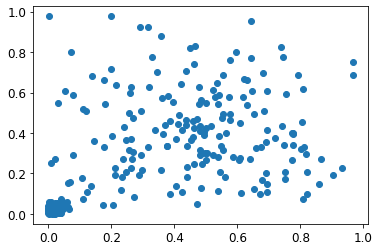

In [18]:
plt.scatter(s['spin1z'][0,:,-1],s['spin2z'][0,:,-1]) 
plt.show()

## Approximants

In [12]:
from pycbc.waveform import td_approximants, fd_approximants
print(td_approximants()) 

['TaylorT1', 'TaylorT2', 'TaylorT3', 'SpinTaylorT1', 'SpinTaylorT4', 'SpinTaylorT5', 'PhenSpinTaylor', 'PhenSpinTaylorRD', 'EOBNRv2', 'EOBNRv2HM', 'TEOBResum_ROM', 'SEOBNRv1', 'SEOBNRv2', 'SEOBNRv2_opt', 'SEOBNRv3', 'SEOBNRv3_pert', 'SEOBNRv3_opt', 'SEOBNRv3_opt_rk4', 'SEOBNRv4', 'SEOBNRv4_opt', 'SEOBNRv4P', 'SEOBNRv4PHM', 'SEOBNRv2T', 'SEOBNRv4T', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'HGimri', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'TaylorEt', 'TaylorT4', 'EccentricTD', 'SpinDominatedWf', 'NR_hdf5', 'NRSur7dq2', 'NRSur7dq4', 'SEOBNRv4HM', 'NRHybSur3dq8', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'TEOBResumS', 'IMRPhenomT', 'IMRPhenomTHM', 'IMRPhenomTP', 'IMRPhenomTPHM', 'TaylorF2', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBN

In [14]:
#print(fd_approximants()) 
# For GW150914 try IMRPhenomXHM
# IMRPhenomXPHM  
# NRSur7dq4 
# TEOBResumS 
# SEOBNRv4HM_ROM

['EccentricFD', 'TaylorF2', 'TaylorF2Ecc', 'TaylorF2NLTides', 'TaylorF2RedSpin', 'TaylorF2RedSpinTidal', 'SpinTaylorF2', 'EOBNRv2_ROM', 'EOBNRv2HM_ROM', 'SEOBNRv1_ROM_EffectiveSpin', 'SEOBNRv1_ROM_DoubleSpin', 'SEOBNRv2_ROM_EffectiveSpin', 'SEOBNRv2_ROM_DoubleSpin', 'SEOBNRv2_ROM_DoubleSpin_HI', 'Lackey_Tidal_2013_SEOBNRv2_ROM', 'SEOBNRv4_ROM', 'SEOBNRv4HM_ROM', 'SEOBNRv4_ROM_NRTidal', 'SEOBNRv4_ROM_NRTidalv2', 'SEOBNRv4_ROM_NRTidalv2_NSBH', 'SEOBNRv4T_surrogate', 'IMRPhenomA', 'IMRPhenomB', 'IMRPhenomC', 'IMRPhenomD', 'IMRPhenomD_NRTidal', 'IMRPhenomD_NRTidalv2', 'IMRPhenomNSBH', 'IMRPhenomHM', 'IMRPhenomP', 'IMRPhenomPv2', 'IMRPhenomPv2_NRTidal', 'IMRPhenomPv2_NRTidalv2', 'SpinTaylorT4Fourier', 'SpinTaylorT5Fourier', 'NRSur4d2s', 'IMRPhenomXAS', 'IMRPhenomXHM', 'IMRPhenomPv3', 'IMRPhenomPv3HM', 'IMRPhenomXP', 'IMRPhenomXPHM', 'SpinTaylorF2_SWAPPER', 'TaylorF2NL', 'PreTaylorF2', 'multiband', 'TaylorF2_INTERP', 'SpinTaylorT5', 'SEOBNRv1_ROM_EffectiveSpin_INTERP', 'SEOBNRv1_ROM_DoubleSp

## Gaussian Noise Model

In [35]:
model = models.GaussianNoise(variable, data,
                                              low_frequency_cutoff = {'H1':25, 'L1':25, 'V1':25},
                                              high_frequency_cutoff = {'H1':500, 'L1':500, 'V1':500},
                                              psds = psds,
                                              static_params = static,
                                              prior = prior,
                                              waveform_transforms = [MchirpQToMass1Mass2()]  # needed to transform m1, m2 to Mc
                                             )
# Run the sampler, note the dimension is 2
smpl2 = sampler.EmceePTSampler(model, 2, n_samples, nprocesses= 8)
_ = smpl2.set_p0()
smpl2.run_mcmc(n_samples)

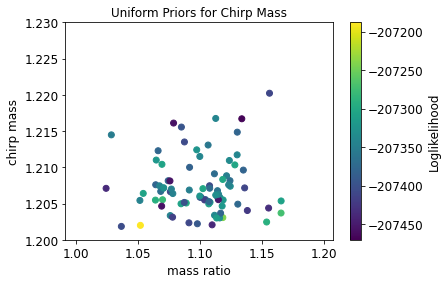

In [47]:
lik2 = smpl2.model_stats['loglikelihood']


s2 = smpl2.samples 
plt.scatter(s2['q'][0,:,-1],s2['mchirp'][0,:,-1], c=lik2[0,:,-1])
plt.xlabel('mass ratio')
plt.ylabel('chirp mass')
c = plt.colorbar() 
plt.ylim(bottom=1.2,top = 1.23)
c.set_label('Loglikelihood')
plt.title('Uniform Priors for Chirp Mass')
plt.show()

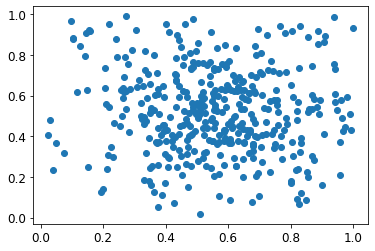

In [37]:
plt.scatter(s2['spin1z'][0,:,-1],s2['spin2z'][0,:,-1]) 
plt.show()

## Normal Distribution for m1 and m2 priors

In [38]:
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle, Gaussian
import numpy 
from pycbc.transforms import MchirpQToMass1Mass2

n_samples = 400 # 50 for tests, > 400 for results, but it is very slow

static = {'f_lower':25.0,
          'approximant':"TaylorF2",
          'polarization':0,
          'inclination':2.4,
          'ra': 3.44615914,
          'dec': -0.40808407,
          'distance':40,
          'f_final':500,
         }

variable = ('mchirp',
            'q',
            'tc',
            'spin1z',
            'spin2z'
            ) 

# change of prior from uniform to eg. log-uniform
standard_dev = 0.15 
variance_mchirp = standard_dev**2

prior = JointDistribution(variable, 
                Uniform(
                    q=(1, 1.2),
                    tc=(m.time-.2, m.time+0.5),
                    spin1z = (0.,1.),## Never larger than one
                    spin2z = (0.,1.) ## Never larger than one 
                ), 
                Gaussian(mchirp=(0.5, 1.5),mchirp_mean=1,
                                        mchirp_var=variance_mchirp)
        )


In [39]:
model = models.GaussianNoise(variable, data,
                                              low_frequency_cutoff = {'H1':25, 'L1':25, 'V1':25},
                                              high_frequency_cutoff = {'H1':500, 'L1':500, 'V1':500},
                                              psds = psds,
                                              static_params = static,
                                              prior = prior,
                                              waveform_transforms = [MchirpQToMass1Mass2()]  # needed to transform m1, m2 to Mc
                                             )
# Run the sampler, note the dimension is 2
smpl3 = sampler.EmceePTSampler(model, 2, 400, nprocesses= 8)
_ = smpl3.set_p0()
smpl3.run_mcmc(400)

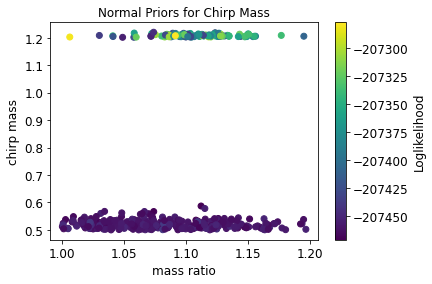

In [48]:
lik3 = smpl3.model_stats['loglikelihood']

s3 = smpl3.samples 
plt.scatter(s3['q'][0,:,-1], s3['mchirp'][0,:,-1], c=lik3[0,:,-1])
plt.xlabel('mass ratio')
plt.ylabel('chirp mass')
c = plt.colorbar()
c.set_label('Loglikelihood')
plt.title('Normal Priors for Chirp Mass')
plt.ylim()
plt.show()

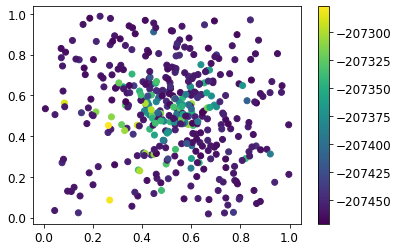

In [51]:
plt.scatter(s3['spin1z'][0,:,-1],s3['spin2z'][0,:,-1], c=lik3[0,:,-1])  
c = plt.colorbar()
plt.show()

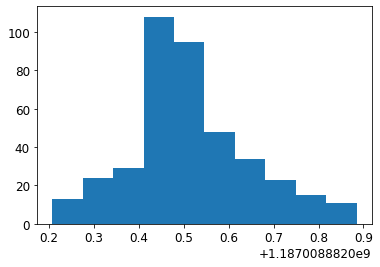

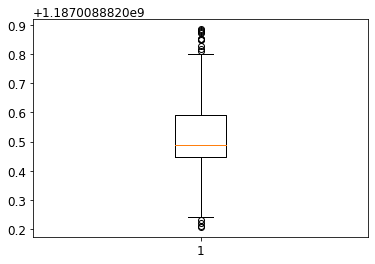

KeyError: 'distance'

In [57]:
plt.hist(s3['tc'][0,:,-1]) 
plt.show() 
plt.boxplot(s3['tc'][0,:,-1]) 
plt.show() 

# Histogram of D_L
_ = plt.hist(s['distance'][0,:,-100::20].flatten(), bins=30)
plt.xlabel('Distance (Mpc)')
plt.ylabel('Bin frequency')
plt.show()